In [1]:
%load_ext Cython 
import numpy as np
from io import StringIO
import time
import threading 
import matplotlib.widgets as widgets
import random as pyrandom
%pylab inline
def linlin(x, smi, sma, dmi, dma): return (x-smi)/(sma-smi)*(dma-dmi)+dmi
from threading import Thread
# from pyo import *
# Audio server
import pyo64 as pyo
# Is 1024 too large for the bufferSize in this case. 
fs = 44100/2
s = pyo.Server(sr=fs, nchnls=2, buffersize=1024, duplex=0).boot()
s.start()
fifo = pyo.FIFOPlayer(maxsize=200, mul=[.3,.3])
mixer = pyo.Mixer()
mixer.addInput(0, fifo);mixer.setAmp(0,0,1)
mixer.addInput(1, fifo);mixer.setAmp(1,1,1)
mixer.out()
fifo.out()



/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


< Instance of FIFOPlayer class >

In [2]:
# Create a rigid window to ramp on/off the audio vector to prevent clipping. 
# But I still hear clipping. 
def makeWindow(s, rampUp = 0.02, rampDown = 0.02):
    w = np.append(np.linspace(0, 1.0, num = int(s * rampUp)), \
      np.ones(s - int(s * rampUp)- int(s * rampDown)))
    w = np.append(w, np.linspace(1.0, 0, num = int(s * rampDown)))
    return w

# Turn list into integer
def list2int(numbers):
    return int(''.join([ "%d"%x for x in numbers]))

# Add some silence to the end
def addSilence(av, bs = 5000):
    return np.append(av, np.zeros(0.2 * bs))

# Slider update function, for the interaction
def sliderUpdate(val):
    global dt, resistant
    sigma = ssigma.val
    exp_table = updateExpTable(sigma, delta_dis)
    dt = sdt.val
    resistant = sresistant.val
    
def sigmaUpdate(val):
    global sigma, exp_table, delta_dis
    sigma = ssigma.val
    exp_table = updateExpTable(sigma, delta_dis)
    
# Create an exponential table for the lookup calculation of potential. 
def createExpTable( dim, sigma, exp_resolution = 1000000 ):
    delta_dis = np.linspace(0.0, dim, num = exp_resolution) # Range of distance difference. 
    tab = updateExpTable(sigma, delta_dis)
    return tab, dim

def updateExpTable(sigma, delta_dis):
    sigma2 = sigma * sigma
    # Try 2 time sigma2
    return exp(- delta_dis/(2 *sigma2))/sigma2

In [3]:
# Currently this plotpot is only for interactive mode. 
# Eventually, data visualisation is not needed because it is aimed just for the sonification. 
# Data visualisation can be provided offline as a comparison. 
# For this method, visulisation is no use for higher dimension data anytaway 
def plotpot(data2d, fig2, sigma=.1, Nx=40, Ny=40):
    # ensure the data sending for plotpot is always in 2d. 
    potmap = zeros((Nx, Ny))
    # The potetnial pot should not be run everytime. 
    for i in range(Nx):
        for j in range(Ny):
            x = float(i)/Nx-0.5
            y = float(j)/Ny-0.5
            potmap[j,i] = potential_ds(data2d, np.array([x,y]), sigma)
    fig2.clf()
    matshow(potmap, cmap=cm.gray, extent=(-0.5,0.5,0.5,-0.5), fignum = 2)    
    fig2.gca().plot(data[:,0], data[:,1], ".")

def initializePot(data, N):  # It takes data and number of rows. 
    sctPlot = ax.scatter(data[:,0], data[:,1],  c="blue", picker = 2, s=[50]*N)
    fig.subplots_adjust(bottom=0.2, left=0.1)
    plt.grid(False)
    plt.axis([-0.6, 0.6, -0.6, 0.6])
    return sctPlot
    

def spectrum(av,fs):
    NFFT = 1024
    figure()
    specgram(audioVec, NFFT = NFFT, Fs = fs, noverlap = 900, cmap= cm.gist_heat)
    show()
    
def stdData(data, dim):
    for i in range(dim):
        # S1 Standardize data. 
        data[:, i] = (data[:,i] - np.mean(data[:,i]))/np.std(data[:,1])
        # limit range to -.5 ~ .5 in each dimension
        data[:,i] = data[:,i] / np.max(np.absolute(data[:,i]))
        data[:,i] = data[:,i] / 2  
    return data

# Generate data set based of dimension and num_of_cluster. 
def dataGen(dim, c, sigma = 0.2, minnr = 50, maxnr = 200):
    for i in range(c):
        nr = pyrandom.randrange(minnr, maxnr, 1)
        meanvec = np.random.rand(dim)
        covmat = sigma**2*cov(np.random.rand(dim, dim))
        dtmp = np.random.multivariate_normal(meanvec, covmat, nr)
        if(i==0): 
            result = dtmp.copy() 
        else:
            result = np.vstack((result, dtmp.copy()))
    return stdData(result, dim)
    

In [4]:
%%cython
cimport numpy as np
import numpy as np
from libc.stdlib cimport rand, malloc, free
from libc.math cimport exp
from matplotlib import pyplot as plt
import time

def potential_ds(np.ndarray[np.float64_t, ndim = 2] data,\
                 np.ndarray[np.float64_t, ndim = 1] grid, double sigma=0.2):
    cdef int N, dim
    N, dim = data.shape[0], data.shape[1]
    cdef double potential, p_sum = 0.0
    cdef int j, i
    cdef double sigma2 = sigma *sigma 
    
    for j in range(N):
        for i in range(dim):
            p_sum += (grid[i] - data[j,i]) * (grid[i] - data[j,i])
            
        potential += -exp (-0.5*p_sum / sigma2)
        p_sum = 0
    return potential
    
# put pos outside and make it a np array. 
def PTSM(np.ndarray[np.float64_t, ndim = 1] pos, np.ndarray[np.float64_t, ndim = 2] X,\
         np.ndarray[np.float64_t, ndim = 1] vel, np.ndarray[np.float64_t, ndim = 1] lookupExp,\
         int table_res, double norm_max, double sigma=0.25,\
         double dt=0.01, double r=0.99, int Nsamp=5000, double compensation = 0.01 ):
    cdef int N, dim
    N, dim = X.shape[0], X.shape[1]
    cdef int i,j, steps,lookupIdx  # These 3 are for iterations. 
    cdef double sigma2,m
    cdef double d,V, v_sum = 0.0
    cdef double force1p_sum = 0.0
    cdef double vel_sum = 0.0
    cdef double *force = <double *>malloc(dim * sizeof(double))
    cdef double *trj = <double *>malloc(Nsamp * (dim+ 1) *sizeof(double))
    cdef double *velocity = <double *>malloc(dim * sizeof(double))
    cdef double *position = <double *>malloc(dim * sizeof(double))
    cdef double *temp = <double *>malloc(dim * sizeof(double)) 
#     cdef double testing = 0.0

    for i in range(dim):
        velocity[i] = vel[i]
        position[i] = pos[i]
        
    sigma2 = sigma * sigma
    m = compensation/sigma2
    #--------------------
       # Force
    for steps in range(Nsamp): 
        for i in range(dim):
            force[i] = 0
        for j in range (N):
            for i in range (dim):
                temp[i] = (position[i] - X[j,i])
                force1p_sum  += temp[i] * temp[i]
            # Look for exp index 
            
            lookupIdx = int(force1p_sum/norm_max * table_res )
#             print lookupIdx
            # Prevent index become much bigger than the table 
            if (lookupIdx >= table_res):
                lookupIdx = table_res - 1
            for i in range (dim):  
#                 print lookupExp[lookupIdx]
                force[i] += -temp[i] * lookupExp[lookupIdx]
               
            force1p_sum = 0
    #------------
    #         Now update pos and vel 
    #         This is the main part to get the trajectory information in terms of the new velocity 
    #         and position
        for i in range(dim):
            # Should be dt /m * force[i], but since m = 1.0
            velocity[i] = r * velocity[i] + dt * force[i] / m 
            # This part doesn't ensure velocity to be 
            # constantly dropping. 
            # A potential solution is ot put m = k/sigma2, This compensates
            position[i] = position[i] + dt * velocity[i]
            vel_sum += velocity[i] 

            #-----------------------  
    #         # Put velocity and new position into the trj array. 
        for i in range(dim + 1):
            if i == 0: # The first column is always given to the velocity
                trj[steps * (dim + 1) + i] =  vel_sum
            else:
                trj[steps * (dim + 1) + i] = position[i - 1]
        vel_sum = 0
#     # put trj into a numpy array. Because you can't return a c-array.              
    resultTrj = np.zeros(Nsamp * (dim + 1), dtype = np.float64)
    resultVel = np.zeros(dim)
    # Move c array to numpy array for return 
    for i in range(Nsamp* (dim + 1)):
        resultTrj[i] = trj[i]     
    for i in range(dim): 
        resultVel[i] = velocity[i]  
    # Transpose matrix
    resultTrj = np.reshape(resultTrj, (-1, dim + 1))  # Correct the matrix shape. 
#     # Free up memories. 
#     print testing
    free(trj)
    free(force)
    free(velocity)
    free(position)
    return resultTrj, resultVel


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: covariance is not positive-semidefinite.


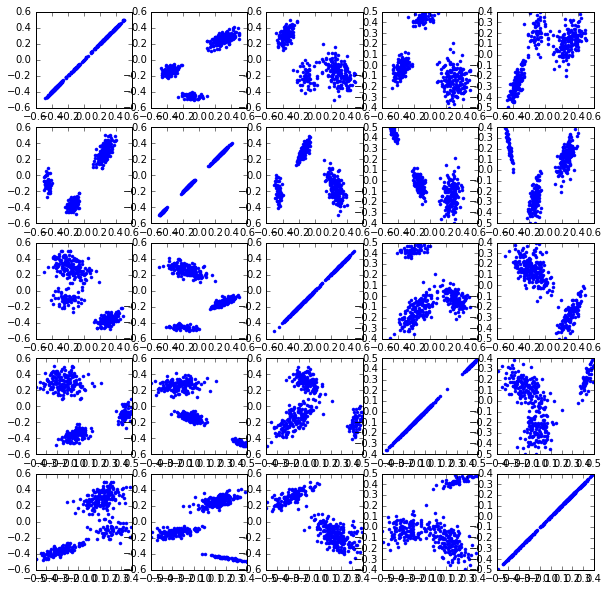

In [5]:
# if testMode == T, a random example is used as the data. 
# else, you can load the actual data txt files. 
testMode = True
if testMode :
    data = dataGen(5, 3, minnr = 50, maxnr = 200)
    N, dim = data.shape[0], data.shape[1]
    pylab.rcParams['figure.figsize'] = (10.0, 10.0)
    dim = 5
    ct=1
    for i in range(dim):
        for j in range(dim):
            subplot(dim, dim, ct)
            plot(data[:, i], data[:,j], ".")   
            ct += 1  

else:
    # Load test data from file 
#     data = np.loadtxt("data/dim032.txt")
    # Still have problem loading csv file. 
    data = np.genfromtxt("data/posture.csv",delimiter=",", skip_header = 1)
    headers = np.genfromtxt("data/posture.csv", dtype = np.str_, delimiter = ",", max_rows = 1 )
    N, dim = data.shape[0], data.shape[1]
#     data = stdData(data, dim)
#     plot(data[:,0], data[:,1], ".")

# Create exp lookup
exp_resolution = 1000000 # Resolution for lookup table
delta_dis = np.linspace(0.0, dim, num = exp_resolution) # Range of distance difference. 
# m_comp = 0.001 # mass compensation
norm_max = dim
sigma = 0.1
exp_table = updateExpTable(sigma, delta_dis)

## Create loop up table for exp()


## Interaction here. 

Offer visualise mode and only sound mode. 

To do list:

1. Adaptive sigma range based on dimensionality. 
2. Not sure if random velocity is the best option
3. OpenCL 
4. Benchmarking
5. Hardware. 


In [25]:
%pylab
fig, ax = plt.subplots()

m_comp =0.02 # mass compensation, before it was 0.01
dt, resistant, sigma = 0.01 , 0.999, 0.06 # init 
t = 0.01 # Time in second per piece
blockSize = 5000   # Buffer size for trajectory

audioVecSize  = t *  blockSize  # I define that 5000 steps will return 1 second of audio 
exp_table, norm_max = createExpTable(dim, sigma, exp_resolution = exp_resolution)
window = makeWindow(audioVecSize, rampUp = 0.02, rampDown = 0.02) # Windowing for audio
audioVec = np.zeros(audioVecSize)
drawResult = True

#-------------------------------------------------#

# Initialize the plot windows. 

sctPlot = initializePot(data, N)

def proc(fifo, stopevent):
    global audioVec
    fifo.put(audioVec)

    
def on_pick(event):
    # In the continuous mode, window shouldn't be used. 
    global data, sigma, resultWindow, resistant, window, audioVecSize,\
    norm_max, audioVec, drawResult
    vel = (rand(dim) - 0.5) * 2
    # Initialise velocity. 
#     vel = rand(dim); vel /= -norm(vel)/1
#     vel = vel * 2
    
    artist = event.artist # Current click event
    ind = np.array(event.ind) # Get the index of the clicked data
    # To prevent retriving multiple points. Always take the first index for PTSM
    pos = np.array(data[ind[0],:])
    # Get PTSM trajectory information
    t0 = time.time()
    trj, junk = PTSM(pos, data, vel, exp_table, exp_resolution, \
                norm_max, sigma = sigma, dt = dt, r = resistant,\
                Nsamp = audioVecSize, compensation = m_comp)
    
    audioVec = trj[:,0] / np.max(np.absolute(trj[:,0])) * window
#     stopevent = threading.Event()
#     producer = threading.Thread(name="Compute audio signal", target=proc, args=[fifo, stopevent])
#     producer.start() 
    print time.time() - t0
    
    if drawResult == True:
        plotpot(data[:, 0:2], fig2 = resultWindow,  sigma = sigma )
        resultWindow.gca().plot(trj[:,1], trj[:,2], "-", lw=0.7, c = "green")
        # Mark the beginning and the end of trajectory . 
        resultWindow.gca().plot(trj[0,1], trj[0,2], "o",  c = "yellow")
        resultWindow.gca().plot(trj[audioVecSize - 1,1], trj[audioVecSize - 1,2], "x",  c = "red")
        resultWindow.gca().axis([-0.6, 0.6, -0.6, 0.6])
        resultWindow.canvas.draw()
    


# ---------------#
# Create a slider for setting up the velocity
axcolor = 'lightgoldenrodyellow'
# Create sliders for sigma and dt. 
axSigma = plt.axes([0.1, 0.1, 0.8, 0.02], axisbg = axcolor)
axDt = plt.axes([0.1, 0.06, 0.8, 0.02], axisbg = axcolor)
axR = plt.axes([0.1, 0.02, 0.8, 0.02], axisbg = axcolor)

ssigma = Slider(axSigma, "Sigma", 0.001, 3.15, valinit=0.06, color='blue')
sdt = Slider(axDt, "dt", 0.001, 0.02, valinit = 0.01, color = 'blue')
sresistant = Slider(axR, "r", 0.999, 1.0, valinit = resistant, color = 'blue')

ssigma.on_changed(sigmaUpdate)
sdt.on_changed(sliderUpdate)
sresistant.on_changed(sliderUpdate)
resultWindow = figure(2, figsize=(8, 8))
fig.canvas.mpl_connect('pick_event', on_pick)



Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


15

0.000984907150269


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.000945091247559
0.00106287002563
0.000982999801636
0.000851154327393
0.000886917114258
0.000921964645386
0.000911951065063
0.000981092453003
0.000965118408203
0.00130009651184
0.00102090835571
0.00100684165955
0.000951051712036
0.000979900360107
0.000985145568848
0.00102305412292
0.0010130405426
0.000996112823486
0.00104689598083
0.000985145568848
0.000971078872681
0.00104999542236
0.000982999801636
0.00101494789124
0.00100016593933
0.000972032546997
0.000982046127319
0.000977039337158
0.000941038131714
0.000988960266113
0.00100207328796
0.0010130405426
0.00104999542236
0.000927925109863
0.00100111961365
0.000926971435547
0.000993967056274
0.000971794128418
0.000971794128418
0.0010449886322
0.00098705291748
0.000946998596191
0.00096607208252
0.00099515914917
0.00100612640381
0.000938892364502
0.00101518630981
0.000999927520752
0.000988960266113
0.000978946685791
0.00101017951965
0.000939846038818
0.000972986221313
0.000816106796265
0.00099778175354
0.000959873199463
0.000990867614746

In [23]:
vel = (rand(dim) - 0.5) * 2
print vel

[ 0.72896639  0.06519753  0.2437611   0.69665739 -0.06325391]


## Continous mode. 

Acutally, this mode is not that urgent for the paper. 

In [29]:
%pylab
fig, ax = plt.subplots()

m_comp =0.02 # mass compensation, before it was 0.01
dt, resistant, sigma = 0.01 , 0.999, 0.06 # init 
t = 1 # Time in second per piece
blockSize = 5000   # Buffer size for trajectory

audioVecSize  = t *  blockSize  # I define that 5000 steps will return 1 second of audio 
exp_table, norm_max = createExpTable(dim, sigma, exp_resolution = exp_resolution)
window = makeWindow(audioVecSize, rampUp = 0.02, rampDown = 0.02) # Windowing for audio
audioVec = np.zeros(audioVecSize)
drawResult = True

#-------------------------------------------------#

# Initialize the plot windows. 

sctPlot = initializePot(data, N)

def proc(fifo, stopevent):
    global audioVec
    fifo.put(audioVec)

    
def on_pick(event):
    # In the continuous mode, window shouldn't be used. 
    global data, sigma, resultWindow, resistant, window, audioVecSize,\
    norm_max, audioVec, drawResult
    vel = (rand(dim) - 0.5) 
    # Initialise velocity. 
#     vel = rand(dim); vel /= -norm(vel)/1
#     vel = vel * 2
    
    artist = event.artist # Current click event
    ind = np.array(event.ind) # Get the index of the clicked data
    # To prevent retriving multiple points. Always take the first index for PTSM
    pos = np.array(data[ind[0],:])
    # Get PTSM trajectory information
    t0 = time.time()
    trj, junk = PTSM(pos, data, vel, exp_table, exp_resolution, \
                norm_max, sigma = sigma, dt = dt, r = resistant,\
                Nsamp = audioVecSize, compensation = m_comp)
    
    audioVec = trj[:,0] / np.max(np.absolute(trj[:,0])) * window
    stopevent = threading.Event()
    producer = threading.Thread(name="Compute audio signal", target=proc, args=[fifo, stopevent])
    producer.start() 
    print time.time() - t0
    
    if drawResult == True:
        plotpot(data[:, 0:2], fig2 = resultWindow,  sigma = sigma )
        resultWindow.gca().plot(trj[:,1], trj[:,2], "-", lw=0.7, c = "green")
        # Mark the beginning and the end of trajectory . 
        resultWindow.gca().plot(trj[0,1], trj[0,2], "o",  c = "yellow")
        resultWindow.gca().plot(trj[audioVecSize - 1,1], trj[audioVecSize - 1,2], "x",  c = "red")
        resultWindow.gca().axis([-0.6, 0.6, -0.6, 0.6])
        resultWindow.canvas.draw()
    


# ---------------#
# Create a slider for setting up the velocity
axcolor = 'lightgoldenrodyellow'
# Create sliders for sigma and dt. 
axSigma = plt.axes([0.1, 0.1, 0.8, 0.02], axisbg = axcolor)
axDt = plt.axes([0.1, 0.06, 0.8, 0.02], axisbg = axcolor)
axR = plt.axes([0.1, 0.02, 0.8, 0.02], axisbg = axcolor)

ssigma = Slider(axSigma, "Sigma", 0.001, 3.15, valinit=0.06, color='blue')
sdt = Slider(axDt, "dt", 0.001, 0.02, valinit = 0.005, color = 'blue')
sresistant = Slider(axR, "r", 0.999, 1.0, valinit = resistant, color = 'blue')

ssigma.on_changed(sigmaUpdate)
sdt.on_changed(sliderUpdate)
sresistant.on_changed(sliderUpdate)
resultWindow = figure(2, figsize=(8, 8))
fig.canvas.mpl_connect('pick_event', on_pick)




Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


15

0.0366680622101
0.0367641448975
0.0380458831787
0.036602973938
0.0364880561829
0.0366539955139
0.0419030189514
0.0360171794891
0.0363709926605
0.0363569259644
0.0362949371338
0.0368061065674
0.0373299121857
0.036700963974
0.0353729724884
0.036698102951
0.0363969802856
0.0352258682251
0.038074016571
0.0369081497192
0.0362780094147
0.037202835083
0.0361490249634
0.0369811058044
0.040599822998
0.0357990264893
0.035609960556
0.0363779067993
0.0361399650574
0.0373919010162
0.0386049747467
0.0370810031891
0.0367078781128
0.0365359783173
0.0358788967133
0.0393209457397
0.0357909202576
0.036248922348
0.038106918335
0.0377459526062
0.0366859436035
0.0366959571838
0.0357818603516
0.0359690189362
0.035285949707
0.0362169742584
0.0369200706482
0.037878036499
0.0394330024719
0.0371201038361
0.0412790775299
0.0360457897186
0.0367960929871
0.0375349521637
0.0370271205902
0.0439369678497
0.0353829860687
0.0362689495087
0.036276102066
0.041023015976
0.0365748405457
0.0364780426025
0.0362808704376
0.035